In [1]:
!pip install matplotlib folium

In [48]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import folium


# Load JSON data from the file
with open('ciclistas.json', 'r') as file:
    json_data = json.load(file)

# Convert JSON data to a pandas DataFrame
riders_df = pd.DataFrame(json_data)

# Display the DataFrame
riders_df.head()

,resistencia,sprint,montana,llano,paves,tecnica,descenso,colinas,agresividad,crono,trabajoequipo,salud,forma,equipo,nombre,apellido
0,91.207,80.285,7.842,93.734,99.670,89.018,11.015,67.150,41.726,14.903,32.961,99,100,Villavante,Ava,Johnson
1,62.076,25.340,0.000,16.559,0.000,10.051,0.000,0.000,1.454,1.069,0.000,52,90,Jaguar,Sophia,Miller
2,67.936,95.691,16.444,80.727,48.005,72.278,66.433,76.086,77.835,34.680,21.202,90,97,Europcar974,Sophia,Williams
3,61.044,69.027,21.612,68.464,7.387,61.358,32.151,68.499,77.463,22.388,4.981,92,99,Squadra_Pirata_24,Isabella,Davis
4,32.978,73.425,7.960,75.744,85.585,57.627,54.780,85.736,66.411,13.278,43.070,51,98,ZG,Oliver,Brown


In [3]:
# Load JSON data from the file
with open('stages.json', 'r') as file:
    json_data = json.load(file)

# Convert JSON data to a pandas DataFrame
df = pd.DataFrame(json_data)

# Display the DataFrame
df.head()

,_id,points,features,abilities,total_distance,name,year,stage,filepath
0,658cc09bc29ae441454ebeac,"[{'lat': 47.49855, 'lon': 4.39061, 'elev': 360...","[{'type': 'hill', 'start_km': 0, 'end_km': 100...","{'Stamina': 8.76, 'Sprint': 14.66, 'Climbing':...",176149.331274,tour-de-france,2024,stage-8-route,/workspace/gpx_scraper/tour-de-france/2024/sta...
1,658cc112c29ae441454ebf03,"[{'lat': 42.83806, 'lon': -2.60983, 'elev': 53...","[{'type': 'flat', 'start_km': 0, 'end_km': 897...","{'Stamina': 10.95, 'Sprint': 6.64, 'Climbing':...",164148.281552,tour-of-the-basque-country,2023,stage-1-route,/workspace/gpx_scraper/tour-of-the-basque-coun...
2,658cc11dc29ae441454ebf07,"[{'lat': 43.2107, 'lon': -2.72167, 'elev': 79....","[{'type': 'flat', 'start_km': 0, 'end_km': 938...","{'Stamina': 8.99, 'Sprint': 2.84, 'Climbing': ...",166411.766950,tour-of-the-basque-country,2023,stage-5-route,/workspace/gpx_scraper/tour-of-the-basque-coun...
3,658cc1bbc29ae441454ebf5b,"[{'lat': 43.42764, 'lon': -5.07282, 'elev': 14...","[{'type': 'flat', 'start_km': 0, 'end_km': 509...","{'Stamina': 20.72, 'Sprint': 0.98, 'Climbing':...",122208.514090,vuelta-spain,2023,stage-17-route,/workspace/gpx_scraper/vuelta-spain/2023/stage...
4,658cc0c9c29ae441454ebec8,"[{'lat': 46.18125, 'lon': 8.85059, 'elev': 218...","[{'type': 'flat', 'start_km': 0, 'end_km': 593...","{'Stamina': 21.56, 'Sprint': 0.8, 'Climbing': ...",182266.188895,tour-de-suisse,2022,stage-6-route,/workspace/gpx_scraper/tour-de-suisse/2022/sta...


In [4]:
stage = df.iloc[0]
print(f'Looking at { stage["name"] } {stage.stage} {stage.year}')

Looking at tour-de-france stage-8-route 2024


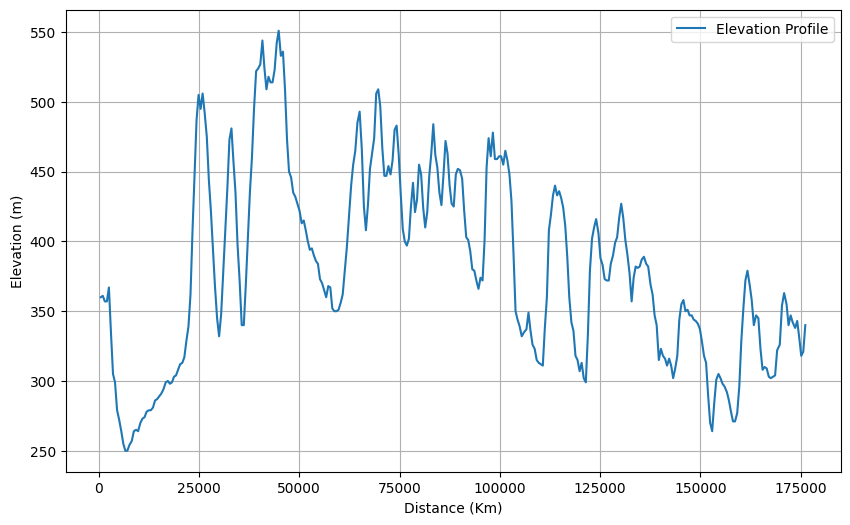

In [5]:


# Convert to DataFrame
stage_df = pd.DataFrame(stage.points)

# Plot the profile chart
plt.figure(figsize=(10, 6))
plt.plot(stage_df['dist'], stage_df['elev'], label='Elevation Profile', marker=None)
plt.xlabel('Distance (Km)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:

# Create a Folium map centered around the first point
m = folium.Map(location=[stage_df['lat'].iloc[0], stage_df['lon'].iloc[0]], zoom_start=9)

# Add a polyline to the map
folium.PolyLine(locations=list(zip(stage_df['lat'], stage_df['lon'])), color='blue', weight=2.5, opacity=1).add_to(m)

# Save map to HTML file and display
#m.save('stage_track_map.html')
m


In [43]:
TIME_STEP = 600  # Each iteration represents 600 seconds
CHECKPOINTS = 5  # Number of checkpoints
DRAFTING_BENEFIT = 0.8  # Riders in a group expend less energy
ENERGY_COST_FLAT = 1.0
ENERGY_COST_CLIMB = 2.0
ENERGY_COST_DESCENT = 0.5
GROUP_DISTANCE_THRESHOLD = 10  # Distance threshold to consider riders in the same group


import math

def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# Function to calculate energy expenditure based on gradient and ability
def calculate_energy(rider, gradient):
    if gradient > 0:
        return gradient * ENERGY_COST_CLIMB / (rider['montana'] + 1)
    elif gradient < 0:
        return abs(gradient) * ENERGY_COST_DESCENT / (rider['descenso'] + 1)
    else:
        return ENERGY_COST_FLAT / ( rider['llano'] + 1)


# Function to calculate speed based on gradient and ability
def calculate_speed(rider, gradient):
    base_speed = 70  # Base speed in km/h
    gradient = gradient / 100  # Convert percentage to a fraction
    if gradient > 0:
        # Uphill
        speed = base_speed * (rider['montana'] / 100.0) * (1 - min(gradient, 1))  # Prevent reducing speed below zero
    elif gradient < 0:
        # Downhill
        speed = base_speed * (rider['descenso'] / 100.0) * (1 + abs(gradient))
    else:
        # Flat
        speed = base_speed * (rider['llano'] / 100.0)
    
    # Ensure speed is not negative and clamp to a minimum speed
    speed =  max(speed, 5.0)  # Ensure a minimum speed of 5 km/h
    return speed/3.6 #pass to m/s

# Function to update groups based on proximity
def update_groups(riders, distance_threshold):
    groups = []
    riders.sort(key=lambda x: x['dist'])
    current_group = [riders[0]]
    
    for i in range(1, len(riders)):
        if abs(riders[i]['dist'] - riders[i-1]['dist']) <= distance_threshold:
            current_group.append(riders[i])
        else:
            groups.append(current_group)
            current_group = [riders[i]]
    
    if current_group:
        groups.append(current_group)
    
    return groups

# Initialize riders' positions and energy
riders_df['dist'] = 0.0
riders_df['energy'] = 100.0  # Starting energy level

riders = riders_df.to_dict('records')

total_distance = stage_df['dist'].max()
print(f'Stage total distance: {total_distance/1000} km')

current_time = 0
checkpoint_intervals = np.linspace(0, total_distance, CHECKPOINTS + 1)[1:]

# Data to store positions at checkpoints
checkpoint_data = {i: [] for i in range(CHECKPOINTS)}

lead_at_km = 0

# Simulation loop through each time step
checkpoint_index = 0
while any(rider['dist'] < total_distance for rider in riders):
    riders_not_completed = [rider for rider in riders if rider['dist'] < total_distance]
    len_not_completed = len(riders_not_completed)
    print(f'Riders still to finish: { len_not_completed } at race time {seconds_to_hms(current_time)}')
    for rider in riders:

        if(rider['dist'] >= total_distance):
            continue #skip finalised riders
            
        if rider['energy'] <= 0:
            current_position = next((i for i, row in stage_df.iterrows() if row['dist'] >= rider['dist']), len(stage_df) - 1)
            gradient = stage_df.iloc[current_position]['gradient']
            speed = 0.8*calculate_speed(rider, gradient)
            
            distance_covered = speed * (TIME_STEP )  # Convert speed to distance covered in this time step
            rider['dist'] += distance_covered

            if rider['dist'] > lead_at_km:
                lead_at_km = rider['dist']
                print(f'Lead at km: {lead_at_km/1000}, with speed: {speed*3.6} km/h at gradient {gradient}')
            continue  # Skip exhausted riders
        
        current_position = next((i for i, row in stage_df.iterrows() if row['dist'] >= rider['dist']), len(stage_df) - 1)
        gradient = stage_df.iloc[current_position]['gradient']
        speed = calculate_speed(rider, gradient)
        
        distance_covered = speed * (TIME_STEP )  # Convert speed to distance covered in this time step
        rider['dist'] += distance_covered

        energy_cost = calculate_energy(rider, gradient)
        rider['energy'] -= energy_cost * (TIME_STEP )
        if rider['dist'] > lead_at_km:
            lead_at_km = rider['dist']
            en = rider['energy']
            print(f'Lead at km: {lead_at_km/1000}, with speed: {speed*3.6} km/h at gradient {gradient} with energy {en}')
        
    # Update groups
    groups = update_groups(riders, GROUP_DISTANCE_THRESHOLD)
    
    # Apply drafting benefit
    for group in groups:
        if len(group) > 1:
            for rider in group:
                rider['energy'] *= DRAFTING_BENEFIT  # Reduce energy consumption if in a group

    # Merge groups if necessary
    new_groups = []
    for i in range(len(groups)):
        if i == 0:
            new_groups.append(groups[i])
        else:
            if abs(groups[i][0]['dist'] - groups[i-1][-1]['dist']) <= GROUP_DISTANCE_THRESHOLD:
                new_groups[-1].extend(groups[i])
            else:
                new_groups.append(groups[i])
    groups = new_groups

    # Checkpoint handling
    if checkpoint_index < len(checkpoint_intervals) and any(rider['dist'] >= checkpoint_intervals[checkpoint_index] for rider in riders):
        checkpoint_data[checkpoint_index] = [{'nombre': rider['nombre'], 'dist': rider['dist'], 'energy': rider['energy']} for rider in riders]
        checkpoint_index += 1

    current_time += TIME_STEP

# Final results
final_results = sorted(riders, key=lambda x: x['dist'], reverse=True)

# Calculate time gaps
for i in range(1, len(final_results)):
    time_gap = (final_results[i-1]['dist'] - final_results[i]['dist']) / calculate_speed(final_results[i-1], 0) * 3600  # Time gap in seconds
    final_results[i]['time_gap'] = time_gap
final_results[0]['time_gap'] = 0



Stage total distance: 176.14933127428566 km
Riders still to finish: 200 at race time 00:00:00
Lead at km: 6.821935148422206, with speed: 40.931610890533236 km/h at gradient 5.164407143243529 with energy 1.0934186872827922
Lead at km: 9.87387097400977, with speed: 59.24322584405863 km/h at gradient 5.164407143243529 with energy 31.32589512763198
Lead at km: 11.064152499954922, with speed: 66.38491499972953 km/h at gradient 5.164407143243529 with energy 38.64070720898778
Riders still to finish: 200 at race time 00:10:00
Lead at km: 12.73535361009472, with speed: 49.48706398582803 km/h at gradient -3.8874212260913166
Lead at km: 12.749891962609116, with speed: 39.418065955105774 km/h at gradient -0.9934480555264867
Lead at km: 16.274933956255456, with speed: 56.5985 km/h at gradient 0.0 with energy -6.228644854805131
Lead at km: 16.457030022123664, with speed: 50.554698032738315 km/h at gradient 0.5055970826773422 with energy 7.539203795387216
Lead at km: 16.767860850364304, with speed: 5

In [47]:
print("Final Results:")
pd.DataFrame(final_results)

Final Results:


,resistencia,sprint,montana,llano,paves,tecnica,descenso,colinas,agresividad,crono,trabajoequipo,salud,forma,equipo,nombre,apellido,dist,energy,time_gap
0,62.689,63.023,100.000,40.130,29.899,32.151,16.838,18.734,7.627,58.652,63.484,86,90,ClubMezkitaKordoba,Oliver,Rodriguez,184834.602014,-1.985813e+01,0.000000
1,28.169,45.264,100.000,55.992,45.134,43.780,12.905,71.699,61.302,22.862,79.938,53,90,Buccacycling,James,Rodriguez,184792.289571,-2.482266e+01,19521.172922
2,64.470,44.685,100.000,64.129,47.409,64.687,27.689,38.761,51.720,52.958,19.030,86,90,Asturconess,Olivia,Davis,184526.336911,-2.482266e+01,87939.768623
3,80.357,23.433,98.315,71.400,11.219,46.549,93.101,92.493,53.421,68.568,33.520,71,100,Budvarka,Ava,Miller,184441.972628,-3.430065e+00,24356.288737
4,94.323,22.708,98.644,77.321,12.424,85.253,91.859,20.981,7.533,34.473,64.634,65,100,El_Realidad,Emma,Brown,183557.857202,-2.140173e+01,229254.420243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000,55.119,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,86,90,TeamMajer,Oliver,Davis,176166.666667,-1.588157e-22,7475.149717
196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,60.033,0.000,53,90,KARM,William,Garcia,176166.666667,-1.588157e-22,0.000000
197,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,62.130,0.000,53,90,KARM,Noah,Williams,176166.666667,-1.588157e-22,0.000000
198,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,68.853,3.671,86,90,SarmiBici,Oliver,Smith,176166.666667,-1.588157e-22,0.000000
